<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/diffusion%20test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
class ResNetBlock(layers.Layer):
    def __init__(self, num_filters):
        super(ResNetBlock, self).__init__()
        self.inputConv = layers.Conv2D(num_filters, 1, padding='same')
        self.conv1 = layers.Conv2D(num_filters, (3, 3), padding='same',activation='LeakyReLU')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(num_filters, (3, 3), padding='same',activation='LeakyReLU')
        self.bn2 = layers.BatchNormalization()

    def call(self, inputs):
        inpx = self.inputConv(inputs)
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return layers.add([x, inpx])

In [129]:
def model():

    input_noise = layers.Input(shape=(28,28,1))
    input_digit = layers.Input(shape=())
    digit = layers.Embedding(100, 100)(input_digit)
    digit = layers.Dense(28*28*7)(digit)
    digit = layers.Reshape((28,28,7))(digit)

    x = layers.concatenate([input_noise, digit])

    x = ResNetBlock(64)(x)

    #x = layers.MaxPool2D(2)(x)

    x = ResNetBlock(64)(x)

    #x = layers.MaxPool2D(2)(x)


    x = ResNetBlock(64)(x)
    #x = layers.UpSampling2D(2)(x)

    x = ResNetBlock(64)(x)
    #x = layers.UpSampling2D(2)(x)

    #x = layers.BatchNormalization()(x)
    x = layers.Conv2D(1,3,1,padding='same',activation=None)(x)

    model = tf.keras.models.Model(inputs=([input_noise,input_digit]), outputs=x)
    model.summary()
    return model

In [130]:
generator = model()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 100)                  10000     ['input_12[0][0]']            
                                                                                                  
 dense_5 (Dense)             (None, 5488)                 554288    ['embedding_5[0][0]']         
                                                                                                  
 input_11 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                            

In [35]:
x_test = tf.expand_dims(x_train,axis = -1)

print(x_test.shape)

(60000, 28, 28, 1)


In [36]:
noise = tf.random.normal(shape=(10,28,28,1),mean=.5,stddev=1)
print(np.max(noise))

3.8165562


In [8]:
def interpolate(array1,array2,factor):
  interpolated_array = tf.math.add(
    tf.multiply(array1, 1.0 - factor),
    tf.multiply(array2, factor))
  return interpolated_array

In [94]:
def noised(input,t_steps):
  step = np.random.randint(0,t_steps-1)
  noise = tf.random.normal(shape=input.shape,mean=.5,stddev=1)
  input_tensor = tf.cast(input,tf.float32)
  output = interpolate(noise,input_tensor,step/t_steps)
  target = interpolate(noise,input_tensor,step+1/t_steps)
  return output, target, step

76


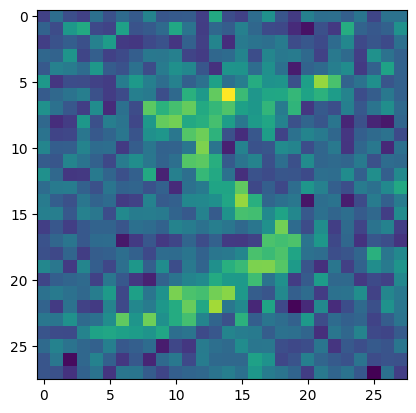

In [99]:
output, noise, step = noised(x_test[0:10],100)

print(step)
plt.imshow(output[0])

In [131]:
model = generator  # Your diffusion model
loss_fn = tf.keras.losses.MeanSquaredError()  # Your loss function
optimizer = tf.keras.optimizers.Adam()
BATCH_SIZE = 64
# Define the training loop
@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        # Add noise to the images
        noisy_images,target,step = noised(images, 100)
        step = np.full((BATCH_SIZE),step)
        # Run the diffusion model
        predictions = generator([noisy_images,step])

        # Compute the loss
        loss = loss_fn(target, predictions)

    # Compute gradients and update the model
    gradients = tape.gradient(loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    tf.print(loss)
    return loss


def train(dataset, epochs):
  for epoch in range(epochs):
    for batch in range(len(dataset) // BATCH_SIZE):

            images = dataset[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]

            train_step(images)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      print(epoch)

In [132]:

EPOCHS = 1000
train(x_test, EPOCHS)

321.991791
289.838
254.661072
227.755188
200.778198
158.525543
124.887459
87.0876923
67.1053
78.9855347
82.0341263
73.0484848
63.1602173
58.872757
56.5745277
53.3919296
51.97752
52.9858
54.7628136
55.1926613
51.4632797
51.09272
44.2434692
41.6219368
41.0082245
42.4663277
42.1883774
40.2116051
38.4785461
39.0298233
39.835
39.5266266
37.5391922
36.9049644
35.398674
37.360527
35.7121582
35.1631126
34.3438377
36.4044571
35.0734253
34.9273491
34.7433548
34.9210854
35.6145706
33.8339729
30.5328293
33.1862106
30.6195621
29.9357357
30.5017834
29.3806973
33.4114799
30.4893169
29.3825493
32.8382492
34.4748077
33.6831169
32.3360214
31.5615711
29.8930721
29.6210384
29.4679432
31.9862366
29.8310204
30.0425453
30.7307129
29.5519867
28.3989601
29.8859119
32.9564629
29.7656021
30.9764977
33.2415924
32.4966507
32.1431046
32.1444168
27.0676689
28.562645
29.9546394
30.0003529
29.3039894
28.7942047
30.7163754
31.0937519
29.4140377
29.0857182
28.2236786
28.9970531
28.4428711
26.7359161
26.188776
26.8140202

KeyboardInterrupt: ignored

In [133]:
current_input = tf.random.normal((1,28,28,1),mean=.5,stddev=1)
for i in range(10):

  step = np.full(1,i)
  step = tf.cast(step,dtype=tf.float32)
  noise = generator([current_input,step])
  current_input = noise
  #current_input = np.expand_dims(current_input,axis=0)

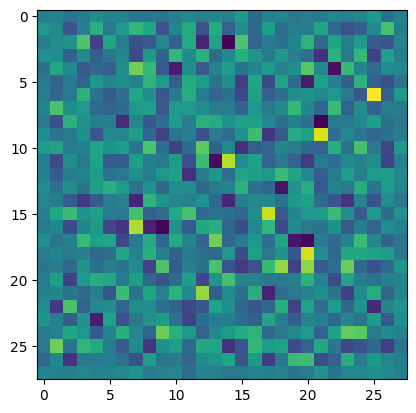

In [134]:
plt.imshow(current_input[0])

In [113]:
print(np.mean(current_input[0]))

-0.07187714
